In [97]:
import pandas as pd
import numpy as np
import matplotlib as plt
from skspatial.objects import LineSegment

In [98]:
SPACING = 0.4
TURNS = 9
STATOR_RADIUS = 20

In [99]:
# create a square shape
# template = [(-1, -1), (1, -1), (1, 1), (-1 , 1)]
# create a triangle
template = [[-1.5, 0], (1, -1.4), (1, 1.4)]
# interpolate the shape using numpy

# create a circle template
# template = [(np.cos(theta), np.sin(theta)) for theta in np.linspace(0, 2*np.pi, 36)]



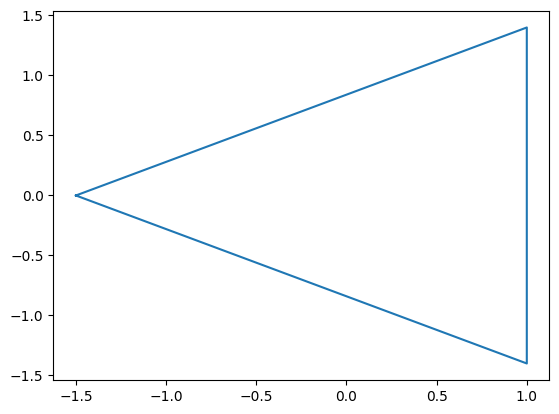

In [100]:
# plot the template shape wrapping around to the first point
plt.pyplot.plot([x for x, y in template] + [template[0][0]], [y for x, y in template] + [template[0][1]])

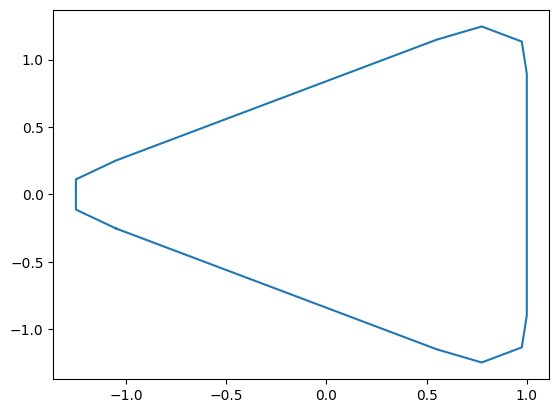

In [101]:
# apply Chaikin's algorithm to the template - corner cuttine
def chaikin(arr, iterations):
    if iterations == 0:
        return arr
    l = len(arr)
    smoothed = []
    for i in range(l):
        x1, y1 = arr[i]
        x2, y2 = arr[(i+1)%l]
        smoothed.append([0.9*x1 + 0.1*x2,0.9*y1 + 0.1*y2])
        smoothed.append([0.1*x1 + 0.9*x2,0.1*y1 + 0.9*y2])
    return chaikin(smoothed, iterations - 1)

template = chaikin(template, 2)
plt.pyplot.plot([x for x, y in template] + [template[0][0]], [y for x, y in template] + [template[0][1]])  

In [102]:
# this speeds things up dramatically as we only have to compute the line intersections once
# there are probably much faster ways of doing this - we're just doing a brute force search
# for the intersections - consult algorithms from games for inspiration...
def get_template_point_cache(template):
    # sweep a line from the origin through 360 degress times the number of turns in 1 degree increments
    # and find the intersection points with the template shape
    cache = {}
    for angle in np.arange(0, 360, 1):
        line = LineSegment(np.array([0, 0]), np.array([1000 * np.cos(np.deg2rad(angle)), 1000 * np.sin(np.deg2rad(angle))]))
        for i in range(len(template)):
            segment = LineSegment(np.array(template[i]), np.array(template[(i + 1) % len(template)]))
            try:
                intersection = line.intersect_line_segment(segment)
                if intersection is not None:
                    cache[angle] = (intersection, segment)
            except ValueError:
                pass
    return cache

def get_points(template, turns, spacing, cache = None):
    if cache is None:
        cache = get_template_point_cache(template)
    points = []
    for angle in np.arange(0, 360 * turns, 1):
        intersection, segment = cache[angle % 360]
        offset = spacing * angle / 360
        vector = np.array(segment.point_a) - np.array(segment.point_b)
        normal = vector / np.linalg.norm(vector)
        # rotate the vector 90 degrees
        normal = np.array([-normal[1], normal[0]])
        # move the intersection point along the normal vector by the spacing
        points.append(intersection + normal * offset)
    return points


In [103]:
cache = get_template_point_cache(template)

In [104]:
points = get_points(template, TURNS, SPACING, cache)

<AxesSubplot: xlabel='x'>

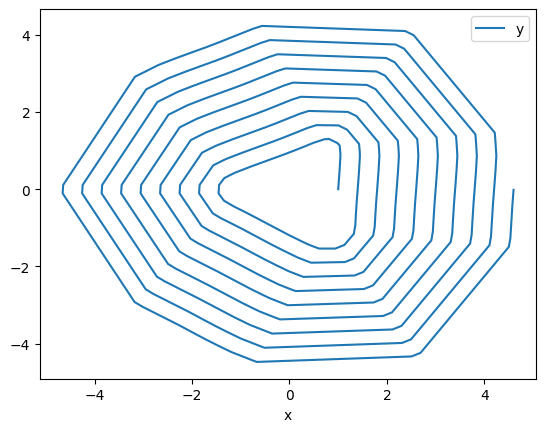

In [105]:
# plot the points
df = pd.DataFrame(points, columns=['x', 'y'])
df.plot.line(x='x', y='y')

<AxesSubplot: xlabel='x'>

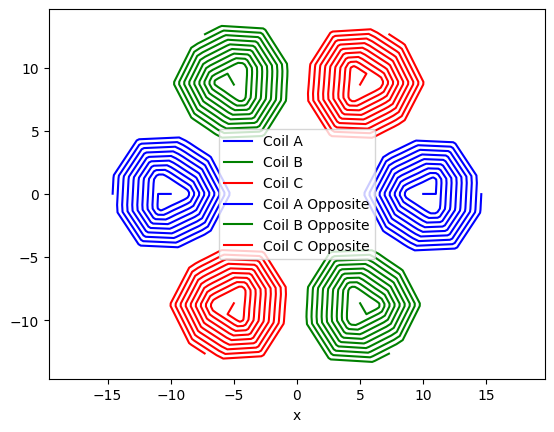

In [106]:
points = [(0,0)] + get_points(template, TURNS, SPACING, cache) 

COIL_CENTER_RADIUS = STATOR_RADIUS/2

angle_A = 0
angle_B = 120
angle_C = 240

# roate the points by the required angle
def rotate(points, angle):
    return [[x * np.cos(np.deg2rad(angle)) - y * np.sin(np.deg2rad(angle)), x * np.sin(np.deg2rad(angle)) + y * np.cos(np.deg2rad(angle))] for x, y in points]

# move the points out to the distance at the requited angle
def translate(points, distance, angle):
    return [[x + distance * np.cos(np.deg2rad(angle)), y + distance * np.sin(np.deg2rad(angle))] for x, y in points]

coil_A = translate(rotate(points, angle_A), COIL_CENTER_RADIUS, angle_A)
coil_B = translate(rotate(points, angle_B), COIL_CENTER_RADIUS, angle_B)
coil_C = translate(rotate(points, angle_C), COIL_CENTER_RADIUS, angle_C)

# cretae the opposite coils
coil_A_opposite = translate(rotate(points, angle_A + 180), COIL_CENTER_RADIUS, angle_A + 180)
coil_B_opposite = translate(rotate(points, angle_B + 180), COIL_CENTER_RADIUS, angle_B + 180)
coil_C_opposite = translate(rotate(points, angle_C + 180), COIL_CENTER_RADIUS, angle_C + 180)

# plot all three coils on the same graph
df = pd.DataFrame(coil_A, columns=['x', 'y'])
ax = df.plot.line(x='x', y='y', label='Coil A', color='blue')
ax.axis('equal')
df = pd.DataFrame(coil_B, columns=['x', 'y'])
df.plot.line(x='x', y='y', ax=ax, label='Coil B', color='green')
df = pd.DataFrame(coil_C, columns=['x', 'y'])
df.plot.line(x='x', y='y', ax=ax, label='Coil C', color='red')

df = pd.DataFrame(coil_A_opposite, columns=['x', 'y'])
df.plot.line(x='x', y='y', ax=ax, label='Coil A Opposite', color='blue')
df = pd.DataFrame(coil_B_opposite, columns=['x', 'y'])
df.plot.line(x='x', y='y', ax=ax, label='Coil B Opposite', color='green')
df = pd.DataFrame(coil_C_opposite, columns=['x', 'y'])
df.plot.line(x='x', y='y', ax=ax, label='Coil C Opposite', color='red')

